# Plot results for predicting hurricane strength (maximum intensity).
author: Elizabeth A. Barnes and Randal J. Barnes

version: v2.0

date: 28 October 2021

In [1]:
import datetime
import os
import pickle
import pprint
import time

import matplotlib as mpl
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


import experiment_settings
from build_data import build_hurricane_data
import shash
from toolbox import custom_round, ceiling_round
import prediction

from silence_tensorflow import silence_tensorflow
silence_tensorflow()

In [2]:
__author__ = "Randal J Barnes and Elizabeth A. Barnes"
__version__ = "1 November 2021"

# EXP_NAME = "intensity101_ALEPCP72"
# EXP_NAME = "intensity8_EPCP48"
# EXP_NAME = "intensity10_EPCP72"
EXP_NAME = "intensity7_AL72"
# EXP_NAME = "intensity5_AL72"
# EXP_NAME = "intensity6_EPCP48"


DATA_PATH = "data/"
MODEL_PATH = "saved_models/"

In [3]:
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
dpiFig = 300.
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

settings = experiment_settings.get_settings(EXP_NAME)
pprint.pprint(settings, width=80)

{'act_fun': 'relu',
 'basin': 'AL',
 'batch_size': 64,
 'distribution': 'shash3',
 'filename': 'nnfit_vlist_intensity_and_track_extended.dat',
 'hiddens': [15, 10],
 'leadtime': 72,
 'learning_rate': 0.0001,
 'loss': 'likelihood',
 'momentum': 0.9,
 'n_epochs': 25000,
 'n_test': 0,
 'n_val': 300,
 'nesterov': True,
 'np_seed': 888,
 'patience': 300,
 'ridge_param': 0.0,
 'target': 'intensity',
 'undersample': False}


## Build the intensity data tensors.

In [4]:
np.random.seed(settings["np_seed"])
(
    x_train,
    onehot_train,
    x_val,
    onehot_val,
    data_summary,
    df_val,
) = build_hurricane_data(DATA_PATH, settings, verbose=2)

{'datafile_path': 'data/nnfit_vlist_intensity_and_track_extended.dat',
 'onehot_train_shape': (872, 3),
 'onehot_val_shape': (300, 3),
 'x_names': ['NCI',
             'DSDV',
             'LGDV',
             'HWDV',
             'AVDV',
             'VMXC',
             'DV12',
             'SLAT',
             'SSTN',
             'SHDC',
             'DTL'],
 'x_train_shape': (872, 11),
 'x_val_shape': (300, 11),
 'y_name': ['OBDV']}


         |   cnt |   min |   25% |   50% |   75% |   max |   avg |   std |   irq
---------+-------+-------+-------+-------+-------+-------+-------+-------+-------
 y_train |   872 | -37.8 |  -7.5 |   0.5 |  10.0 |  72.5 |  3.05 | 16.66 |  17.5
 y_val   |   300 | -39.2 |  -6.0 |   0.8 |   9.9 |  69.5 |  4.06 | 17.41 |  15.9




## Load the model

In [5]:
NETWORK_SEED = [settings["np_seed"]][0]
MODEL_NAME   = EXP_NAME + "_" + f"network_seed_{NETWORK_SEED}_numpy_seed_{settings['np_seed']}"
model        = tf.keras.models.load_model(MODEL_PATH + MODEL_NAME + "_model", compile=False)

## Make predictions

In [6]:
# make predictions
mu_pred, sigma_pred, gamma_pred, tau_pred = prediction.params(x_val, model)    
    
# convert y_pred to intensity corrections    
ann_correction  = prediction.percentile_value(mu_pred,sigma_pred,gamma_pred,tau_pred,percentile_frac=.5)
true_correction = df_val['OBDV'].to_numpy()  

# convert to full intensity predictions
cons_intensity  = df_val['VMXC'].to_numpy()
ann_intensity   = cons_intensity + ann_correction
true_intensity  = cons_intensity + true_correction

# covert ann prediction bounds
ann_low_correction  = prediction.percentile_value(mu_pred,sigma_pred,gamma_pred,tau_pred,percentile_frac=.25)
ann_high_correction = prediction.percentile_value(mu_pred,sigma_pred,gamma_pred,tau_pred,percentile_frac=.75)
iqr                 = ann_high_correction - ann_low_correction

ann_low_intensity   = ann_low_correction + cons_intensity
ann_high_intensity  = ann_high_correction + cons_intensity

# compute errors
ann_error  = np.abs(ann_intensity - true_intensity)
cons_error = np.abs(cons_intensity - true_intensity)

ann_mae    = np.mean(ann_error)
cons_mae   = np.mean(cons_error)

print(ann_mae, cons_mae)
print('percent improvement by ANN = ' + str(np.round(100.*(cons_mae-ann_mae)/cons_mae,2)) + '%')

11.231569192409516 12.403
percent improvement by ANN = 9.44%


# Plots

In [7]:
### for white background...
plt.rc('text',usetex=False)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
            ax.xaxis.set_ticks([]) 

### Make dataframe

In [8]:
data = np.concatenate((x_val, 
                       mu_pred[:,np.newaxis], 
                       sigma_pred[:,np.newaxis], 
                       gamma_pred[:,np.newaxis],           
                       tau_pred[:,np.newaxis],
                       
                       iqr[:,np.newaxis],
                       
                       ann_error[:,np.newaxis],
                       cons_error[:,np.newaxis], 
                       
                       ann_correction[:,np.newaxis],                                              
                       true_correction[:,np.newaxis],
                       
                       cons_intensity[:,np.newaxis],                                   
                       ann_intensity[:,np.newaxis],
                       true_intensity[:,np.newaxis],
                       
                       ann_low_intensity[:,np.newaxis],
                       ann_high_intensity[:,np.newaxis],
                      ),
                      axis=1)

all_names = data_summary['x_names'].copy()
for a in ('mu_pred', 
          'sigma_pred', 
          'gamma_pred', 
          'tau_pred', 
          'iqr', 
          'ann_error', 
          'cons_error', 
          'ann_correction', 
          'true_correction', 
          'cons_intensity',
          'ann_intensity',
          'true_intensity',
          'ann_low_intensity',
          'ann_high_intensity',
         ):
    all_names.append(a)
df = pd.DataFrame(data=data, columns=all_names)

### Errors vs uncertainty estimates

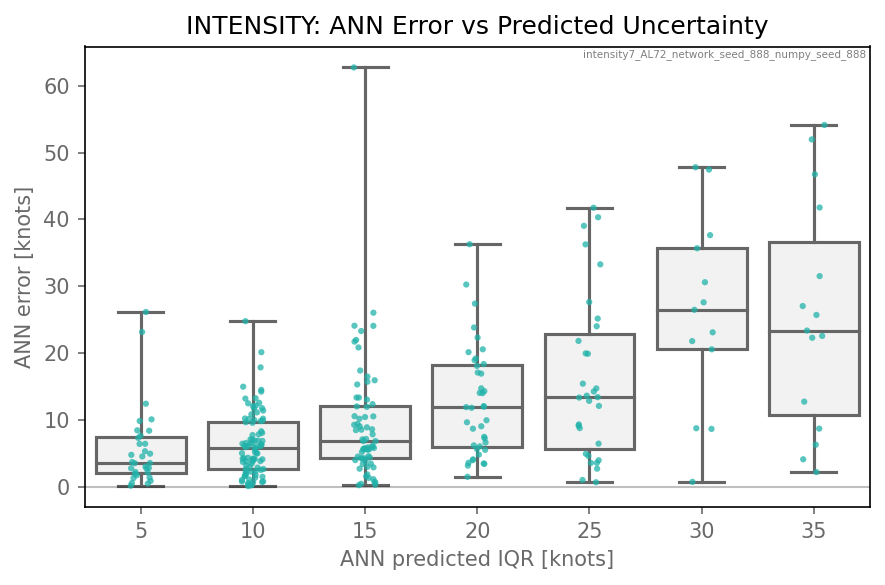

In [27]:
if(settings['target']=='intensity'):
    if(EXP_NAME[-4:]=='AL72'):
        ROUND_BASE = 5
    
        df_plot = df.copy()
        df_plot['iqr'] = pd.Series(df_plot['iqr']).apply(lambda x: custom_round(x, base=ROUND_BASE))
        #-----------------------------------------------------------------------------

        for xvar in ('iqr',):#('sigma', 'range_66'):
            yvar = 'ann_error'

            plt.figure()
            g = sns.boxplot(
                data=df_plot,
                x=xvar, y=yvar,
                whis=100,
            )
            plt.setp(g.artists, edgecolor = '.4', facecolor='.95')
            plt.setp(g.lines, color='.4')
            ax = sns.stripplot(x=xvar, y=yvar, data=df_plot, color="lightseagreen", size=3.,alpha=.75,)
            plt.axhline(y=0,color='k', alpha=.25, linewidth=1)

            plt.xlim(-.5,6.5)

            plt.ylabel('ANN error [knots]')
            plt.xlabel('ANN predicted IQR [knots]')
            plt.title('INTENSITY: ANN Error vs Predicted Uncertainty')
            plt.tight_layout()

            plt.text(.995, .995, MODEL_NAME,
                horizontalalignment='right',
                verticalalignment='top',
                color='tab:gray',
                fontsize=5,
                transform = ax.transAxes)    

            plt.savefig('figures/proposal_plots/' + MODEL_NAME + '_boxplot_' + xvar + '_' + yvar + '_cutoff40.png', dpi=dpiFig)    
            plt.show()

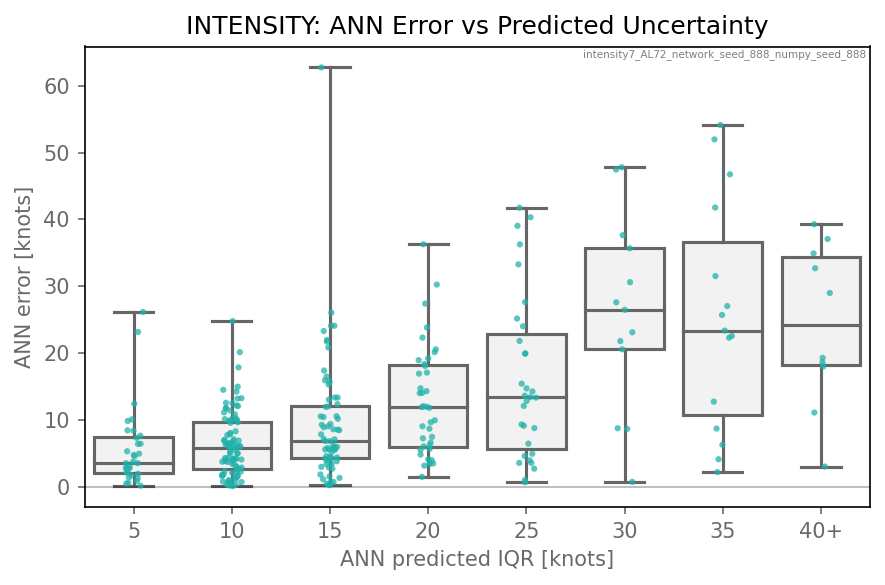

In [28]:
if(settings['target']=='intensity'):
    if(EXP_NAME[-4:]=='AL72'):
        ROUND_BASE = 5
    
        df_plot = df.copy()
        df_plot['iqr'] = pd.Series(df_plot['iqr']).apply(lambda x: custom_round(x, base=ROUND_BASE))
        df_plot['iqr'] = pd.Series(df_plot['iqr']).apply(lambda x: ceiling_round(x, ceiling=40))
        #-----------------------------------------------------------------------------

        for xvar in ('iqr',):#('sigma', 'range_66'):
            yvar = 'ann_error'

            plt.figure()
            g = sns.boxplot(
                data=df_plot,
                x=xvar, y=yvar,
                whis=100,
            )
            plt.setp(g.artists, edgecolor = '.4', facecolor='.95')
            plt.setp(g.lines, color='.4')
            ax = sns.stripplot(x=xvar, y=yvar, data=df_plot, color="lightseagreen", size=3.,alpha=.75,)
            plt.axhline(y=0,color='k', alpha=.25, linewidth=1)

            # g.set_xticks(range(len(df))) # <--- set the ticks first
            g.set_xticklabels(['5','10','15','20','25','30','35','40+'])    

            plt.ylabel('ANN error [knots]')
            plt.xlabel('ANN predicted IQR [knots]')
            plt.title('INTENSITY: ANN Error vs Predicted Uncertainty')
            plt.tight_layout()

            plt.text(.995, .995, MODEL_NAME,
                horizontalalignment='right',
                verticalalignment='top',
                color='tab:gray',
                fontsize=5,
                transform = ax.transAxes)    

            plt.savefig('figures/proposal_plots/' + MODEL_NAME + '_boxplot_' + xvar + '_' + yvar + '_cleaned_40+.png', dpi=dpiFig)    
            plt.show()

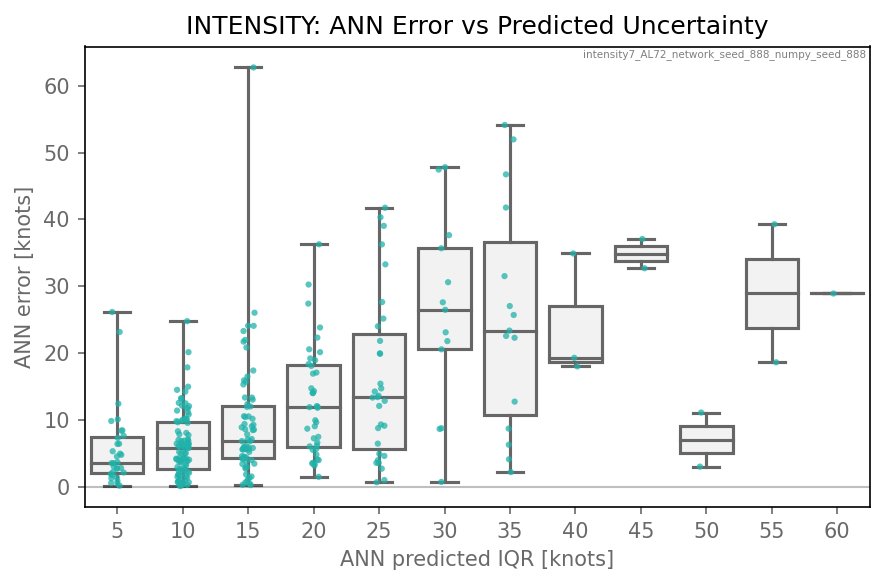

In [29]:
if(settings['target']=='intensity'):
    if(EXP_NAME[-4:]=='AL72'):
        ROUND_BASE = 5
    elif(EXP_NAME[-2:]=='72'):
        ROUND_BASE = 10
else:
    ROUND_BASE = 150
    
df_plot = df.copy()
df_plot['iqr'] = pd.Series(df_plot['iqr']).apply(lambda x: custom_round(x, base=ROUND_BASE))
#-----------------------------------------------------------------------------

for xvar in ('iqr',):#('sigma', 'range_66'):
    yvar = 'ann_error'
    
    plt.figure()
    g = sns.boxplot(
        data=df_plot,
        x=xvar, y=yvar,
        whis=100,
    )
    plt.setp(g.artists, edgecolor = '.4', facecolor='.95')
    plt.setp(g.lines, color='.4')
    ax = sns.stripplot(x=xvar, y=yvar, data=df_plot, color="lightseagreen", size=3.,alpha=.75,)
    plt.axhline(y=0,color='k', alpha=.25, linewidth=1)
    
    plt.ylabel('ANN error [knots]')
    plt.xlabel('ANN predicted IQR [knots]')
    plt.title('INTENSITY: ANN Error vs Predicted Uncertainty')
    plt.tight_layout()
    
    plt.text(.995, .995, MODEL_NAME,
        horizontalalignment='right',
        verticalalignment='top',
        color='tab:gray',
        fontsize=5,
        transform = ax.transAxes)    
    
    plt.savefig('figures/proposal_plots/' + MODEL_NAME + '_boxplot_' + xvar + '_' + yvar + '.png', dpi=dpiFig)    
    plt.show()

### ANN prediction of consensus error

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Avant Garde


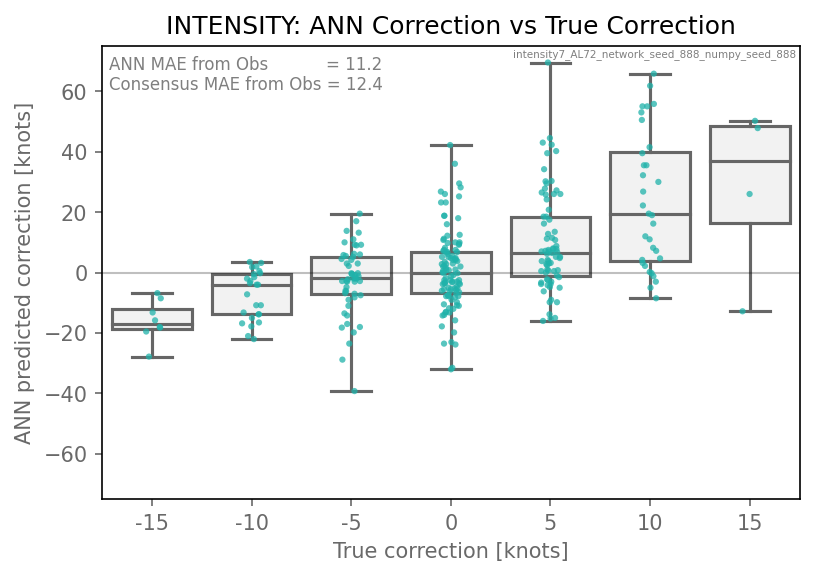

In [10]:
if(settings['target']=='intensity'):
    ROUND_BASE = 5  
    
df_plot = df.copy()
df_plot['ann_correction'] = pd.Series(df_plot['ann_correction']).apply(lambda x: custom_round(x, base=ROUND_BASE))

for xvar in ('ann_correction',):
    yvar = 'true_correction'
    
    plt.figure()
    g = sns.boxplot(
        data=df_plot,
        x=xvar, y=yvar,
        whis=100,
        palette='gray',
    )
    plt.setp(g.artists, edgecolor = '.4', facecolor='.95')
    plt.setp(g.lines, color='.4')
    ax = sns.stripplot(x=xvar, y=yvar, data=df_plot, color="lightseagreen", size=3.,alpha=.75,)
    plt.axhline(y=0,color='k', alpha=.25, linewidth=1)

    plt.xlabel('True correction [knots]')
    plt.ylabel('ANN predicted correction [knots]')
    plt.title('INTENSITY: ANN Correction vs True Correction')
    
    # get y-axis limits of the plot
    # low, high = plt.ylim()
    # bound = max(abs(low), abs(high))
    # set new limits
    bound = max(np.abs(plt.ylim()))
    plt.ylim(-bound, bound)    

    plt.text(.995, .995, MODEL_NAME,
        horizontalalignment='right',
        verticalalignment='top',
        color='tab:gray',
        fontsize=5,
        transform = ax.transAxes)   

    t = 'ANN MAE from Obs           = ' + str(np.round(ann_mae,1)) + '\nConsensus MAE from Obs = ' + str(np.round(cons_mae,1))
    plt.text(.01,.98,t,
        horizontalalignment='left',
        verticalalignment='top',
        color='tab:gray',
        fontsize=8,
        transform = ax.transAxes)   
                 
    plt.savefig('figures/proposal_plots/' + MODEL_NAME + '_boxplot_' + xvar + '_' + yvar + '.png', dpi=dpiFig)    
    plt.show()

### Scatter plot of actual values

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Avant Garde


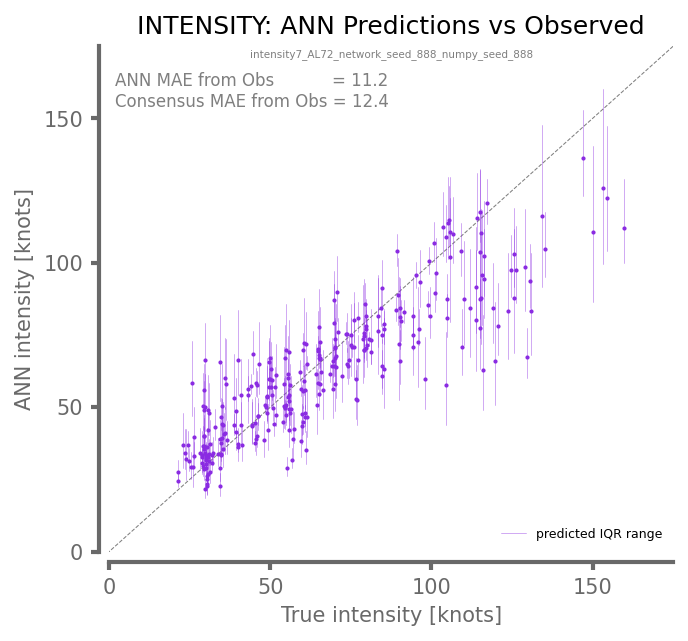

In [11]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

x_bin = np.around(np.arange(0,1.02,.01),3)
perc = np.nan*np.zeros((x_bin.shape[0]-1,2))

#----------------------------------------------------------------
fig = plt.figure(figsize=(3.75*1.25,3.5*1.25))
#----------------------------------------------------------------
ax = plt.subplot(111)
plt.plot((-500,500),(-500,500),'--',linewidth=.5,color='gray')

adjust_spines(ax, ['left', 'bottom'])
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('dimgrey')
ax.spines['bottom'].set_color('dimgrey')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')


for i in np.arange(0,len(true_intensity)):
    leg_label = None
    if(i==0):
        leg_label = 'predicted IQR range'

    wiggle = np.random.normal(loc=0.0, scale=1.)        
    plt.plot(true_intensity[i]+wiggle,
             ann_intensity[i],
             marker='.',
             markersize=2,
             color='blueviolet',
             ls='none',
             label=None,
            )
    plt.plot((true_intensity[i]+wiggle,true_intensity[i]+wiggle),
             (ann_low_intensity[i],ann_high_intensity[i]),
             '-',
             color='blueviolet',
             linewidth=.25,
             alpha = .75,
             label=leg_label,
            )

# LEGEND ----------------------------------------
array_of_xlabels = (np.around(np.arange(-200.,250,50),3)).astype(int)
array_of_ylabels = (np.around(np.arange(-200.,250,50),3)).astype(int)
plt.xticks(array_of_xlabels,map(str,array_of_xlabels))
plt.yticks(array_of_ylabels,map(str,array_of_ylabels))

plt.xlabel('True intensity [knots]')
plt.ylabel('ANN intensity [knots]')
plt.title('INTENSITY: ANN Predictions vs Observed', fontsize=12)

plt.xlim(0,175)
plt.ylim(0,175)

t = 'ANN MAE from Obs           = ' + str(np.round(ann_mae,1)) + '\nConsensus MAE from Obs = ' + str(np.round(cons_mae,1))
plt.text(.01,.95,t,
    horizontalalignment='left',
    verticalalignment='top',
    color='tab:gray',
    fontsize=8,
    transform = ax.transAxes) 

plt.legend(fontsize=6,frameon=False,loc=4)

# FINAL STUFF------------------------------------
plt.tight_layout()

plt.text(.5, .995, MODEL_NAME,
    horizontalalignment='center',
    verticalalignment='top',
    color='tab:gray',
    fontsize=5,
    transform = ax.transAxes)

plt.savefig('figures/proposal_plots/' + MODEL_NAME + '_scatter_prediction_vs_observed_full.png', dpi=dpiFig)    
plt.show()

## Example sample

1.3764533996582031 11.0


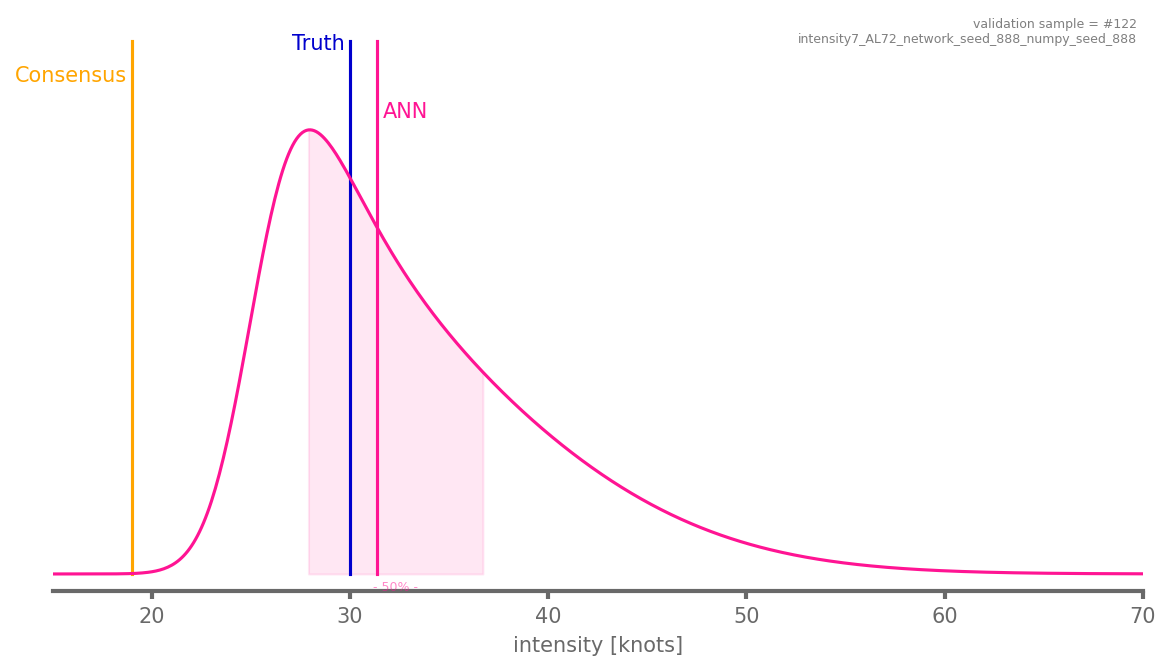

ATCF           AL21
Name          VICKY
Date           2020
time          91412
ftime(hr)        72
NCI               2
OBDV           11.0
DSDV           -5.7
LGDV           -3.0
HWDV            0.0
AVDV            3.0
VMXC           19.0
DV12           10.0
SLAT           22.1
SSTN           25.9
SHDC           41.6
DTL          1938.4
NCT               3
OBDX            3.4
AVDX          -37.5
EMDX         -129.5
EGDX          168.2
HWDX           -0.0
LONC           37.6
OBDY         -122.2
AVDY           66.7
EMDY           77.8
EGDY         -144.4
HWDY            0.0
LATC           22.7
OBDR          122.2
OBDA           -1.5
BTV            30.0
BTLAT          21.6
BTLON          37.6
Name: 22058, dtype: object


In [12]:
#----------------------------------------------------------------
fig = plt.figure(figsize=(3.75*1.25*2,2*2.5))
#----------------------------------------------------------------
ax = plt.subplot(111)

adjust_spines(ax, ['left', 'bottom'])
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_color('dimgrey')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
plt.yticks([])

#--------------------------------
index = 122
line_height = .04
if(EXP_NAME[-4:]=='AL72'):
    xlimit = 70
    ha_cons = 'right'
    x_cons = -5    
else:
    xlimit = 120
    ha_cons = 'left'
    x_cons = 5

x = np.arange(0,200,.1)
d = shash.prob(x,mu_pred[index]+df['cons_intensity'][index],sigma_pred[index],gamma_pred[index],tau_pred[index])
line_height = np.max(d)*1.2

plt.plot((df['true_intensity'][index],df['true_intensity'][index]),(0,line_height),'-',color='mediumblue')
plt.annotate("Truth", (df['true_intensity'][index],line_height*.975), color='mediumblue', xytext=(-5,5), textcoords='offset pixels',horizontalalignment='right')

plt.plot((df['cons_intensity'][index],df['cons_intensity'][index]),(0,line_height),'-',color='orange')
plt.annotate("Consensus", (df['cons_intensity'][index],line_height*.925), color='orange', xytext=(x_cons,0), textcoords='offset pixels',horizontalalignment=ha_cons)

plt.plot(x,d,'-',color='deeppink')

x_shade = np.logical_and((x>=df['ann_low_intensity'][index]), (x<=df['ann_high_intensity'][index]))
plt.fill_between(x,d,np.zeros(np.shape(d)),x_shade, color='deeppink',alpha=.1)
plt.annotate("- 50% -", (df['ann_low_intensity'][index]+df['iqr'][index]/2,0.), color='deeppink', alpha=.5,xytext=(0,-6), fontsize=6, textcoords='offset pixels',horizontalalignment='center', verticalalignment='top')

plt.plot((df['ann_intensity'][index],df['ann_intensity'][index]),(0,line_height),'-',color='deeppink')
plt.annotate("ANN", (df['ann_intensity'][index],line_height*.85), color='deeppink', xytext=(5,0), textcoords='offset pixels',horizontalalignment='left', verticalalignment='bottom')

print(df['ann_error'][index],df['cons_error'][index])
plt.xlabel('intensity [knots]')

plt.xlim(15,xlimit)   
plt.ylim(-line_height/80,line_height*1.05)    
ax = plt.gca()
plt.text(.995, .995, 'validation sample = #' + str(index) + '\n' + MODEL_NAME,
    horizontalalignment='right',
    verticalalignment='top',
    color='tab:gray',
    fontsize=6,
    transform = ax.transAxes)    
    
plt.savefig('figures/proposal_plots/' + MODEL_NAME + '_intensity_visualization_sample' + str(index) + '.png', dpi=dpiFig)    
plt.show()

print(df_val.iloc[index])
